In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import eli5
from sklearn.feature_extraction import DictVectorizer

Using TensorFlow backend.


In [0]:
!pip install eli5

In [0]:
!pip install skater

In [55]:
income = pd.read_csv("income.csv")
col = pd.Categorical(income.high_income)
income["high_income"] = col.codes

income.drop(['fnlwgt', 'education'], axis=1, inplace=True)  

print(income.head())
print(income.columns)

   age          workclass  ...  native_country high_income
0   39          State-gov  ...   United-States           0
1   50   Self-emp-not-inc  ...   United-States           0
2   38            Private  ...   United-States           0
3   53            Private  ...   United-States           0
4   28            Private  ...            Cuba           0

[5 rows x 13 columns]
Index(['age', 'workclass', 'education_num', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
       'hours_per_week', 'native_country', 'high_income'],
      dtype='object')


In [56]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
age               32561 non-null int64
workclass         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
high_income       32561 non-null int8
dtypes: int64(5), int8(1), object(7)
memory usage: 3.0+ MB


In [0]:


class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ] 

class CategoricalTransformer( BaseEstimator, TransformerMixin ):
      #Class constructor method that takes a boolean as its argument
  def __init__(self, new_features=True):
    self.new_features = new_features

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    if self.new_features:
      # Treat ? workclass as unknown
      df['workclass']= df['workclass'].replace('?','Unknown') 
      # Two many category level, convert just US and Non-US
      df.loc[df['native_country']!=' United-States','native_country'] = 'non_usa' 

    # convert columns to categorical
    for name in df.columns.to_list():
      col = pd.Categorical(df[name])
      df[name] = col.codes
    
    #returns numpy array
    return df

# Categrical features to pass down the categorical pipeline 
categorical_features = income.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline 
numerical_features = income.select_dtypes("int64").columns.to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                         ('cat_transformer', CategoricalTransformer())
                                         ]
                                )
# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('std_scaler', MinMaxScaler()) 
                                       ]
                              )

# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('categorical_pipeline', categorical_pipeline),
                                                               ('numerical_pipeline', numerical_pipeline)
                                                               ])


In [180]:

X_train, X_test, y_train, y_test = train_test_split(income.drop(labels="high_income",axis=1),
                                                    income["high_income"],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=income["high_income"])

X_train_new = full_pipeline_preprocessing.fit_transform(X_train, y_train)
X_train_cat = categorical_pipeline.fit_transform(X_train,y_train)
print(X_train['workclass'].value_counts(), X_train_cat['workclass'].value_counts())
# print(marital_df)
best_features = SelectKBest(chi2, k=9)

X_train_new = best_features.fit_transform(X_train_new, y_train)

Private              18099
 Self-emp-not-inc     2041
 Local-gov            1704
 ?                    1473
 State-gov            1053
 Self-emp-inc          894
 Federal-gov           765
 Without-pay            13
 Never-worked            6
Name: workclass, dtype: int64 8    18099
5     2041
2     1704
0     1473
6     1053
4      894
1      765
7       13
3        6
Name: workclass, dtype: int64


In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22792 entries, 24029 to 5800
Data columns (total 12 columns):
age               22792 non-null int64
workclass         22792 non-null object
education_num     22792 non-null int64
marital_status    22792 non-null object
occupation        22792 non-null object
relationship      22792 non-null object
race              22792 non-null object
sex               22792 non-null object
capital_gain      22792 non-null int64
capital_loss      22792 non-null int64
hours_per_week    22792 non-null int64
native_country    22792 non-null object
dtypes: int64(5), object(7)
memory usage: 2.3+ MB


In [93]:
clf = RandomForestClassifier(
                        bootstrap=True, class_weight=None,
                        criterion='gini', max_depth=None,
                        max_features='auto', max_leaf_nodes=12,
                        min_impurity_decrease=0.0,
                        min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0,
                        n_estimators=800, n_jobs=None,
                        oob_score=True, random_state=42,
                        verbose=0, warm_start=False
    )


clf.fit(X_train_new, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=12,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [0]:

X_test_new = full_pipeline_preprocessing.fit_transform(X_test, y_test)
X_test_new = best_features.fit_transform(X_test_new, y_test)
predictions = clf.predict(X_test_new)

In [124]:
print(clf.oob_score_)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0.847281941031941
0.8518347919545525
[[4704  241]
 [ 724  844]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4945
           1       0.78      0.54      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.74      0.77      6513
weighted avg       0.85      0.85      0.84      6513



In [125]:
importances = clf.feature_importances_

columns_name = income.columns[best_features.get_support(indices=True)].tolist()

new_df = pd.DataFrame(list(zip(columns_name,importances)), columns=['Features', 'Importances'])
new_df

,Features,Importances
0,workclass,0.136420
1,education_num,0.008147
2,marital_status,0.302944
3,relationship,0.007608
4,sex,0.048493
5,capital_gain,0.197794
6,capital_loss,0.236118
7,hours_per_week,0.032754
8,native_country,0.029721


In [131]:
eli5.explain_weights_df(clf, feature_names=columns_name)

,feature,weight,std
0,marital_status,0.302944,0.199386
1,capital_loss,0.236118,0.095762
2,capital_gain,0.197794,0.088804
3,workclass,0.136420,0.172676
4,sex,0.048493,0.067185
5,hours_per_week,0.032754,0.030306
6,native_country,0.029721,0.040307
7,education_num,0.008147,0.022501
8,relationship,0.007608,0.023672


In [150]:
eli5.show_weights(clf, feature_names=columns_name)

Weight,Feature
0.3029 ± 0.3988,marital_status
0.2361 ± 0.1915,capital_loss
0.1978 ± 0.1776,capital_gain
0.1364 ± 0.3454,workclass
0.0485 ± 0.1344,sex
0.0328 ± 0.0606,hours_per_week
0.0297 ± 0.0806,native_country
0.0081 ± 0.0450,education_num
0.0076 ± 0.0473,relationship


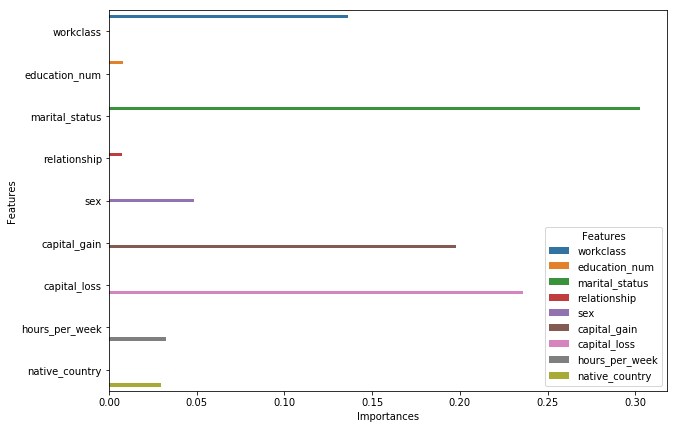

In [127]:
plt.figure(figsize=(10,7))
sns.barplot(x='Importances', y='Features', data=new_df, hue='Features')

In [157]:
print("Real label: ", y_test.iloc[2])
print("Predicted label: ",predictions[2])

eli5.show_prediction(clf, X_test_new[2],
                     feature_names=columns_name, 
                     show_feature_values=True)

Real label:  1
Predicted label:  1


In [0]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(training_data=X_test_new, training_labels=y_test, 
                             feature_names=columns_name)

im_model = InMemoryModel(clf.predict_proba, examples=X_train_new, 
                         target_names=['$50K or less', 'More than $50K'])

2019-10-16 00:40:56,088 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[9/9] features ████████████████████ Time elapsed: 7 seconds

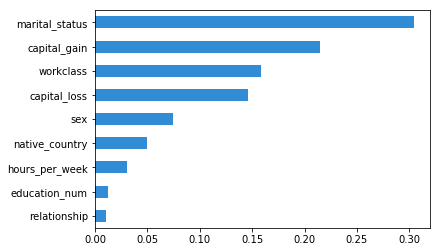

In [135]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, 
                                                               n_samples=23000)

2019-10-16 00:41:59,576 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 7 seconds

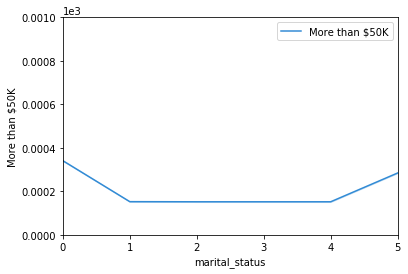

In [136]:
partial_plot = interpreter.partial_dependence.plot_partial_dependence(['marital_status'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = partial_plot[0][1].set_ylim(0, 1) 


In [71]:
X_train['marital_status'].value_counts()

 Married-civ-spouse       11999
 Never-married             8502
 Divorced                  3560
 Separated                  826
 Widowed                    811
 Married-spouse-absent      332
 Married-AF-spouse           18
Name: marital_status, dtype: int64

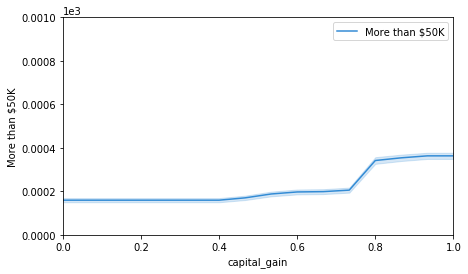

In [138]:
partial_plot = interpreter.partial_dependence.plot_partial_dependence(['capital_gain'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=300, 
                                                           with_variance=True, figsize = (7, 4),progressbar=False)

yl = partial_plot[0][1].set_ylim(0, 1) 
# s, e = partial_plot[0][1].get_xlim()
# xl = partial_plot[0][1].set_xticks(np.arange(s, e, 0.1))

2019-10-16 00:43:16,127 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[7/7] grid cells ████████████████████ Time elapsed: 8 seconds

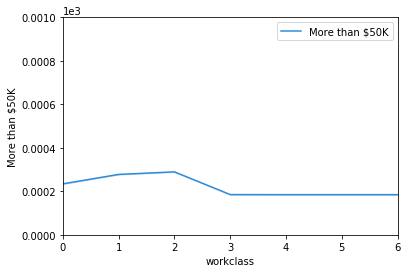

In [139]:
partial_plot = interpreter.partial_dependence.plot_partial_dependence(['workclass'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = partial_plot[0][1].set_ylim(0, 1) 

In [31]:
X_train['workclass'].value_counts()

Private              18099
 Self-emp-not-inc     2041
 Local-gov            1704
 ?                    1473
 State-gov            1053
 Self-emp-inc          894
 Federal-gov           765
 Without-pay            13
 Never-worked            6
Name: workclass, dtype: int64

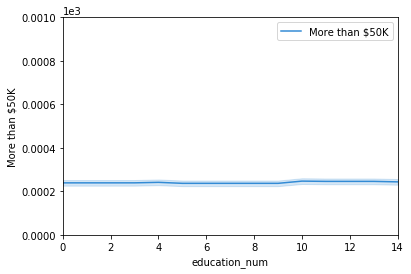

In [140]:
partial_plot = interpreter.partial_dependence.plot_partial_dependence(['education_num'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=300, 
                                                           with_variance=True, figsize = (6, 4),
                                                           progressbar=False)
yl = partial_plot[0][1].set_ylim(0, 1) 
#s, e = partial_plot[0][1].get_xlim()
# xl = partial_plot[0][1].set_xticks(np.arange(s, e, 16))

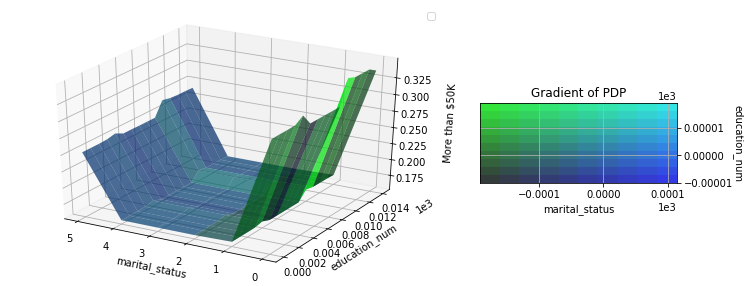

In [35]:
plots_2D = interpreter.partial_dependence.plot_partial_dependence(
    [('marital_status', 'education_num')], 
                            im_model, grid_range=(0,1), 
                            n_samples=23000,
                            figsize=(12, 5),
                            grid_resolution=100,
                            progressbar=False)
